# Using Machine Learning to Create an Expected Goals (xG) Model
## Kip Badgery
### Final results and visualisations are shown at the end of this notebook

In this project, I use a data set that contains data from just over 11000 shot attempts to develop an expected goals (xG) model. Expected goals is a metric that predicts the probability that a given shot will go in. 

The data set contains the following features that I will use to create this model:

- Shot distance
- Shot angle
- Whether the shot was a rebound (Boolean)
- Whether the shot occured shortly after the reception of a pass (Boolean)
- Whether the puck crossed the central line on the ice prior to the shot (Boolean)
- Whether the shot is a one-timer (Boolean)
- Whether the shot occured on the rush (Boolean)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Data Import and Pre-processing
Before I import the data, one important aspect to consider is the effect that empty net goals will have on the model. Because of the occurance of empty net goals, xG may be slightly skewed when training a model that incorporates data from shots that occur when a goalie is pulled. A model that incorporates this data will very likely overestimate the xG of all shots, particularily those from distance and from outside of the offensive zone.

This is a factor that must be considered depending on the application of the xG model. If the model was to be used to give players feedback about where they should shoot, the model should not be trained using data from shots that occur when the opposing goalie is pulled. However, if the models goal is simply to predict the number of goals that occur given a sample of shots, all shots should be included.

I will create a model that is used for the former case. As use cases such as this are more likely to be useful for giving feedback to players. Because of this, I have created a new data set (shots_without_last_3_minutes.csv) that removes data that occurs within the last 3 minutes of the third period.

Because I won't be using data from the last 3 minutes of the 3rd period, I will also not use the time and period in which the shot occurs as features. Although it is possible that the effect of fatigue on both players and goalies may have an effect on xG, I think this data is very likely to cause overfitting. 

In [2]:
dataset = pd.read_csv('shots_without_last_3_minutes.csv')
X = dataset.iloc[:, 4:].values
y = dataset.iloc[:, 1].values

# No need to encode categorical data as all categorical features are already in boolean form

# Feature Scaling, necessary for some ML models such as ANN
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

C:\Users\Rick\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Models

An important consideration for the model is that it should be able to learn relationships between features. This is important in this particular problem because it is likely that the effect that certain features have on xG will vary heavily depending on the values of other features. For example, the fact that a shot is a one-timer may be more important (for determining xG) if the shot is following a rebound, as opposed to a normal shot.

I chose the following 3 algorithms to test. The hyperparmeters of the ANN and KNN were chosen by mainpulating them and observing the results of cross-validation, using r-squared across varying xG ranges as the performance metric.

First, I chose the k-nearest neighbours (KNN) algorithm. This algorithm finds the closest points in the training data set and uses these to estimate the value of the point it is trying to predict. This is perhaps the most intuitive approach and follows the same logic that one would likely use if they were attempting to create this model by hand. For example, if one was trying to find the xG of a wrist shot from the top of the faceoff circle, they would likely look at similar shots and use the shooting percentage in those situations to estimate xG.

In [3]:
# KNN
from sklearn.neighbors import KNeighborsRegressor
KNN = KNeighborsRegressor(n_neighbors=250)

Next, I chose the Random Forest (RF) algorithm. The random forest algorithm combines a number of decision trees, which essentially work like flow charts. These decision trees are excellent at handling feature interaction, and combining them into a random forest prevents overfitting.

In [4]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor
RF = RandomForestRegressor()

Finally, I chose to use an Artificial Neural Network (ANN). Built using the human brain as a model, Neural Networks's generally outperform other machine learning algorithms in most tasks. They are particularily good at learning feature interaction and finding abstract patterns in data.

For the ANN, I decided to use the architecture of a classification algorithm. By using the sigmoid activation function in the output layer, and the binary cross-entropy loss function, the ANN will output the predicted likelihood that a shot is a goal, just like a classification algorithm. This predicted likelihood is then the xG estimate.

I decided to use this method instead of a regression architecture (output layer activation: linear, loss function: mean squared error) because:

1) It performed better

2) The linear activation function in the regression architecture occasionally gave negative values

In [5]:
# ANN
from keras.models import Sequential
from keras.layers import Dense

ANN = Sequential()
ANN.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(X[0,:])))
ANN.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu'))
ANN.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
ANN.compile(optimizer = 'adam', loss = 'binary_crossentropy')

C:\Users\Rick\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Validation

First, the data set is split into 2 sets: a training and validation set, and a test set.

In [6]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

Next, the training and validation set is partitioned into 5 folds, to be used for cross validation

In [7]:
# Partitioning data for k-fold cross-validation
from sklearn.model_selection import KFold
n_folds = 5
kf = KFold(n_splits=n_folds)

Next, the results from the cross validation are used to get an estimate of the perforance of the regeressor. The intial performance metric used is the total number of goals in a data set. When a models predict function is used, the model outputs a number between 0 and 1 for each shot, this number is the probability that the shot will go in, or xG. Given a sufficiently large sample, which we have here, summing the predicted xG of each shot in a data set should approximate the actual number of goals scored in that same data set.

In [8]:
# initialize variable for prediction array
y_pred_KNN = []
y_pred_RF = []
y_pred_ANN = []
y_actual_CV = []

# Cross validate using training and validation set
for train_index, val_index in kf.split(X_train_val):

    X_train = X_train_val[train_index]
    X_val = X_train_val[val_index]
    
    y_train = y_train_val[train_index]
    y_val = y_train_val[val_index]

    KNN.fit(X_train, y_train)
    y_pred_KNN.extend(KNN.predict(X_val))
    
    RF.fit(X_train, y_train)
    y_pred_RF.extend(RF.predict(X_val))
    

    ANN.fit(X_train, y_train, batch_size = 10, epochs = 20, verbose=0) # To see the progression of the loss function set verbose to 1
    y_pred_ANN.extend(ANN.predict(X_val))

    y_actual_CV.extend(y_val)
    
print("Actual number of goals: ", np.sum(y_actual_CV))
print("KNN prediction: ", round(np.sum(y_pred_KNN),1), "Error: ", abs(round(100*(1-np.sum(y_pred_KNN)/np.sum(y_actual_CV)),1)),"%")
print("RF prediction: ", round(np.sum(y_pred_RF),1), "Error: ", abs(round(100*(1-np.sum(y_pred_RF)/np.sum(y_actual_CV)),1)),"%")
print("ANN prediction: ", round(np.sum(y_pred_ANN),1), "Error: ", abs(round(100*(1-np.sum(y_pred_ANN)/np.sum(y_actual_CV)),1)),"%")

Actual number of goals:  493
KNN prediction:  455.0 Error:  7.7 %
RF prediction:  550.7 Error:  11.7 %
ANN prediction:  512.1 Error:  3.9 %


Not surprisingly, the artificial neural network has the best performance. Now it should be considered that simply comparing the predicted number of goals and actual goals is not sufficient. This is because it is possible that the model overestimates the xG of one group of data points, while underestimating another. In this case, these two cases could offset one another and still end up predicting the correct number of goals. 

Note: It would also be possible that the model predicts each shot to have the same chance of going in, with the predicted xG of each shot simply being the average shooting percentage, in which case it would predict the correct number of goals for a random dataset. Fortunately, we can quickly see this isn't the case by showing an example of the output of the regressor (See Below).

In [9]:
print("Predicted xG for 5 shots from the test set",'\n',np.round(ANN.predict(X_test[0:6]),3))

Predicted xG for 5 shots from the test set 
 [[0.036]
 [0.02 ]
 [0.035]
 [0.023]
 [0.01 ]
 [0.097]]


To evaluate the model for all regions, I will sort the training and validation data by predicted xG obtained from the best model, in this case, the ANN. Then, the data will be partitioned into equal sections (The first section will have the shots with the lowest predicted xG, the second section the shots with the next lowest predicted xG etc.).

By comparing the predicted number of goals to the actual number of goals within each of these sections, we should be able to better evaluate the performance of the model. From this, we can use the r-squared score of the two sections as our final performance metric.

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def model_performance(n_sections, y_actual, y_pred, plot_title):
    
    idx_sort = np.argsort(y_pred, axis = None) # finding the indices to sort data by predicted xG
   

    y_pred_sorted = np.array(y_pred)[idx_sort] # sorting the predicted output array by xG
    y_actual_sorted = np.array(y_actual)[idx_sort] # sorting the output array containing the actual number of goals in the same order as predicted xG vector
    
    partitions = np.array(np.round(np.linspace(0,len(y_actual),n_sections+1)[:],0)) # indices which seperate each section of data
    partitions = partitions.astype(int)
        
    goals_predicted=np.zeros((n_sections,1)) # initialize array for the predicted number of goals in each xG range
    goals_actual=np.zeros((n_sections,1)) # initialize array for the actual number of goals in each xG range
    
    for i in range (0,n_sections):
        goals_predicted[i]=np.sum(y_pred_sorted[partitions[i]:partitions[i+1]])
        goals_actual[i]=np.sum(y_actual_sorted[partitions[i]:partitions[i+1]])
    
        # plotting the results and displaying r-squared  

    plt.plot(goals_predicted,goals_actual,'ro')
    plt.title(plot_title)
    plt.xlabel('Predicted Number of Goals')
    plt.ylabel('Actual Number of Goals')
    plt.show()

    r2=r2_score(goals_actual,goals_predicted)
    print("R-squared Score: ", round(r2,3))

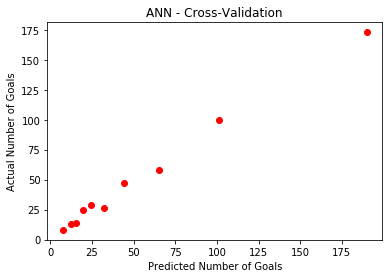

R-squared Score:  0.981


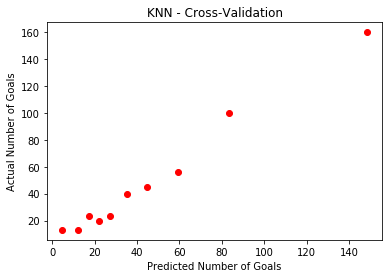

R-squared Score:  0.972


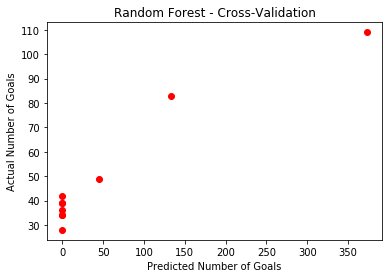

R-squared Score:  -12.429


In [11]:
n_sections_val = 10

model_performance(n_sections_val, y_train_val, y_pred_ANN, "ANN - Cross-Validation")
model_performance(n_sections_val, y_train_val, y_pred_KNN, "KNN - Cross-Validation")
model_performance(n_sections_val, y_train_val, y_pred_RF, "Random Forest - Cross-Validation")

Using the R-squared scores from above, we can see that the KNN and ANN are both able to predict the number of goals with reasonable accuracy in all xG ranges. However, the random forest becomes unusable, and does a very poor job at predicting xG in both the low and high xG ranges. This begins to make sense when thinking about how a decision tree works. As the only possible output numbers it has seen during training are 0 or 1, the individual trees are attempting to make a binary prediction. When we then move through the various trees within the random forest, each one will likely only output a 0 or a 1. This means that all of the trees for low xG shots show a 0 (hence the prediction of zero goals for low xG shots) because every single tree has decided it is more likely that it is not a goal. As a result, the model then substantially overesimates the xG of high scoring chances in an attempt to minimize the overall error.

Next, we test the models on the test set to attain a final performance measure. Because the cross validation set was used to tune the ANN and KNN, these models may be biased towards that set. Because of this, their performance must be tested on the test set.

In [12]:
# fitting the models using all of the training and validation data
KNN.fit(X_train_val, y_train_val)
ANN.fit(X_train_val, y_train_val, batch_size = 10, epochs = 20, verbose=0)

In [13]:
# generating predictions for the test set
ANN_test_pred = ANN.predict(X_test)
KNN_test_pred = KNN.predict(X_test)

Again, we can examine the ability for the models to predict the number of goals at different xG ranges. I will again use the r-squared between predicted and actual goals as the performance metric.

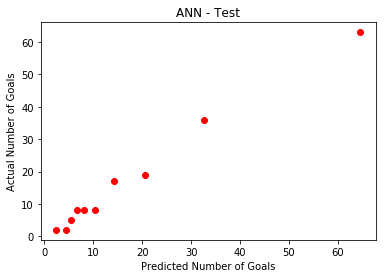

R-squared Score:  0.989


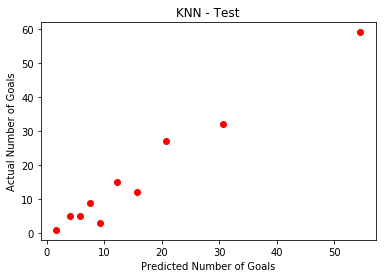

R-squared Score:  0.957


In [14]:
n_sections_test = 10

model_performance(n_sections_test, y_test, ANN_test_pred, "ANN - Test")
model_performance(n_sections_test, y_test, KNN_test_pred, "KNN - Test")

Again, both the KNN model and the ANN do a good job of predicting the number of goals in different xG regions. 

# Visualisations
To visualize the data, I first built a function that populates a grid with hypothetical shots, and then use the model to generate a heat map to display the most dangerous scoring areas for different types of shots. The input parameters (e.g. is_rebound, is_fast_attack) can be varied depending on the type of shots that one is interested in.

In [15]:
# function inputs are 1(True) or 0(False) e.g. if interested in shots on the rush, put input 1 for is_fast_attack
def xg_grid(is_rebound,is_pass_before,is_cross_line,is_one_touch,is_fast_attack):

    from PIL import Image
    I = Image.open('Half_ice.png')

    I_width = np.size(I)[0]
    I_height = np.size(I)[1]
    net_location = [int(I_width/2),40] # X and Y coordinates of the center of the net in the image, this is where the angle and distance will be measured from

    distance_scaler = 30.5/I_height # used to scale the distances from xy coordinates of image to real distance in m
    
    # initialize grid with zero xG everywhere
    xG_grid_ANN = np.zeros((I_height,I_width))
    xG_grid_KNN = np.zeros((I_height,I_width))

    # populate shot grid with predicted xG at every point

    for x in range (0,I_width):
        for y in range (0,I_height):


            # create a hypotheical "shot" from this location 
            if x > net_location[0]: # if the shot is coming from the right hand side of the ice

                shot_distance = np.sqrt((x-net_location[0])**2 + (y - net_location[1])**2) # 

                if x-net_location[0] == 0 and y-net_location[1] >= 0: # if the shot comes from directly infront of net (causes arctan div by 0 error)
                    shot_angle = 90
                elif x-net_location[0] == 0 and y-net_location[1] < 0: # if the shot comes from directly behind net (causes arctan div by 0 error)
                    shot_angle = -90
                else:
                    shot_angle = np.rad2deg(np.arctan((y-net_location[1])/(x-net_location[0]))) # measured from goal line


                shot_features = np.zeros((1,len(X[0,:])))
                shot_features[0,0] = shot_distance*distance_scaler # set distance of shot
                shot_features[0,1] = shot_angle # set angle of shot
                shot_features[0,2] = is_rebound
                shot_features[0,3] = is_pass_before
                shot_features[0,4] = is_cross_line
                shot_features[0,5] = is_one_touch
                shot_features[0,6] = is_fast_attack

                # Scale features using previously fit scaler
                shot_features = sc.transform(shot_features)

                # populate xG grid with the xG of the hypothetical shot that was just created
                xG_grid_ANN[y,x] = ANN.predict(shot_features) 
                xG_grid_KNN[y,x] = KNN.predict(shot_features)

            else: # if the shot is coming from the left hand side of the ice
                shot_distance = np.sqrt((net_location[0]-x)**2 + (y - net_location[1])**2) #

                if net_location[0]-x == 0 and y-net_location[1] >= 0: # if the shot comes from directly inline with the net (causes arctan div by 0 error)
                    shot_angle = 90
                elif net_location[0]-x == 0 and y-net_location[1] < 0: # if the shot comes from directly inline with the net (causes arctan div by 0 error)
                    shot_angle = -90
                else:
                    shot_angle = np.rad2deg(np.arctan((y-net_location[1])/(net_location[0]-x))) # measured from goal line

                shot_features = np.zeros((1,len(X[0,:])))
                shot_features[0,0] = shot_distance*distance_scaler # distance of shot
                shot_features[0,1] = shot_angle # angle of shot
                shot_features[0,2] = is_rebound
                shot_features[0,3] = is_pass_before
                shot_features[0,4] = is_cross_line
                shot_features[0,5] = is_one_touch
                shot_features[0,6] = is_fast_attack
                
                
                # Scale features using previously fit scaler
                shot_features = sc.transform(shot_features)
                
                # populate xG grid with the xG of the hypothetical shot that was just created
                xG_grid_ANN[y,x] = ANN.predict(shot_features) 
                xG_grid_KNN[y,x] = KNN.predict(shot_features)
    
    return xG_grid_ANN, xG_grid_KNN

Next I created a function used to visualize xG for different shot parameters.

In [16]:
def xG_plot(xG_grid,title):
    
    fig, ax = plt.subplots(1, 1)
    #display image
    from PIL import Image
    I = Image.open('Half_ice.png')
    ax.imshow(I)
    # create semi-transparent contour map
    cb = ax.contourf(np.flipud(xG_grid),100, alpha=.6, antialiased=True, cmap='jet')
    plt.title(title)
    plt.colorbar(cb)
    plt.axis('off')
    plt.show()

Now for the best part! Using the model to look at xG contour maps for different types of shots.

## General Shots

First, we can look at general shots. For the ANN, the high xG in a diamond shape near the net makes sense. In general we would expect that shots taken close to the net and at a minimal angle should have the best chance of going in. We can see from the KNN heat map that while it predicts the same number of goals overall, it is flawed in areas that are less commonly shot from. This can be seen when looking at shots both behind the net, as well as from outside of the blue line. It also does not predict the higher xG levels that the ANN does in very high risk scoring chances. Because the KNN model simply looks for the nearest neighbours of the data point, and does not make an attempt to ensure that the neighbours are equally spaced around it, issues arise. Because more shots occur inside the blue line than outside, a shot taken outside of the blue line will have the majority of its neighbours exist closer to the net, resulting in an inflated xG. Similarily, this explains the odd xG of shots from behind the net.

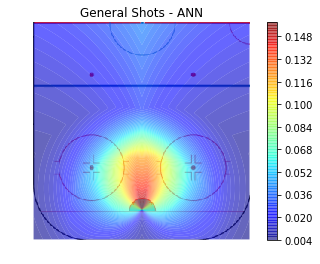

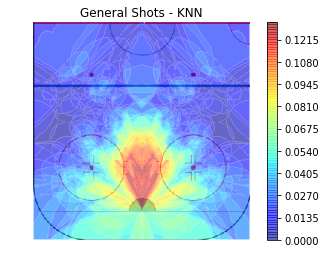

In [17]:
xG_grid_ANN, xG_grid_KNN = xg_grid(0,0,0,0,0)

xG_plot(xG_grid_ANN,'General Shots - ANN')
xG_plot(xG_grid_KNN,'General Shots - KNN')

## One-Timer Rebounds
Next we can look at one-timer rebounds, we see that in general the xG is higher, this makes sense as the goalie is more likely to be out of position. Again, while the results of the KNN model look reasonable for areas that are commonly shot from, it struggles from areas that are rarely shot from.

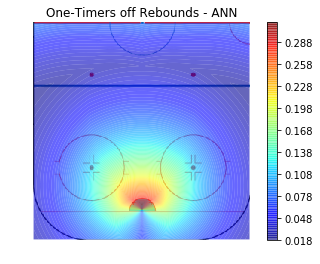

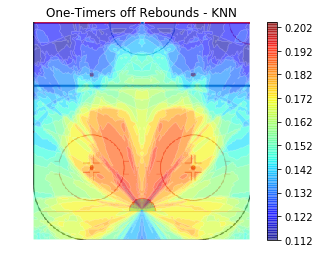

In [18]:
xG_grid_ANN, xG_grid_KNN = xg_grid(1,0,0,1,0)

xG_plot(xG_grid_ANN,'One-Timers off Rebounds - ANN')
xG_plot(xG_grid_KNN,'One-Timers off Rebounds - KNN')

## Shots Taken on the Rush

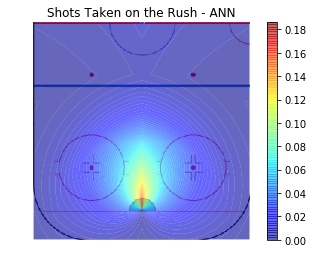

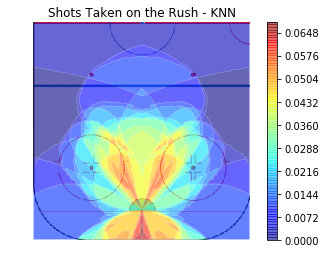

In [19]:
xG_grid_ANN, xG_grid_KNN = xg_grid(0,0,0,0,1)

xG_plot(xG_grid_ANN,'Shots Taken on the Rush - ANN')
xG_plot(xG_grid_KNN,'Shots Taken on the Rush - KNN')

## Cross-Ice One Timers (not on the Rush)
For these shots, the models don't do a great job of determining the xG of shots from behind the net, likely because there were very few of these in the data set.

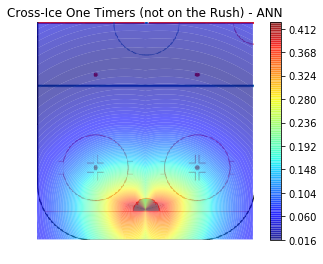

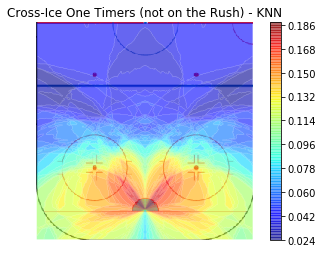

In [20]:
xG_grid_ANN, xG_grid_KNN = xg_grid(0,1,1,1,0)

xG_plot(xG_grid_ANN,'Cross-Ice One Timers (not on the Rush) - ANN')
xG_plot(xG_grid_KNN,'Cross-Ice One Timers (not on the Rush) - KNN')

## Cross-Ice One Timers on the Rush

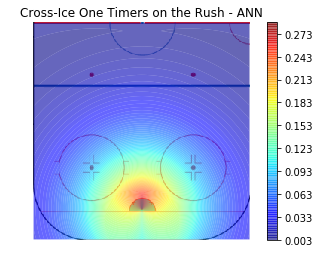

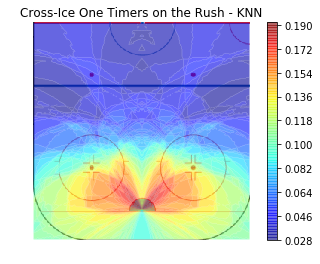

In [21]:
xG_grid_ANN, xG_grid_KNN = xg_grid(0,1,1,1,1)

xG_plot(xG_grid_ANN,'Cross-Ice One Timers on the Rush - ANN')
xG_plot(xG_grid_KNN,'Cross-Ice One Timers on the Rush - KNN')